This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

# Week 3 Homework Submission

Your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:

- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2

# Downloading and transforming training data with augmentation
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85, 1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

# Downloading and transforming test data
test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=v2.ToTensor()  # Direct transformation to tensor for test data
)

# Splitting training data into training and validation sets
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, validation_data = random_split(
    training_data, [train_size, val_size],
    generator=torch.Generator().manual_seed(55)  # Ensuring reproducibility
)

# Defining batch size for data loaders
batch_size = 128

# Optimizing DataLoader creation for faster loading times
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    pin_memory=True,  # Speeds up data transfer to GPU
    shuffle=True,     # Shuffling training data
    num_workers=4     # Parallelizing data loading
)

val_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,    # No need to shuffle validation data
    num_workers=4
)

/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


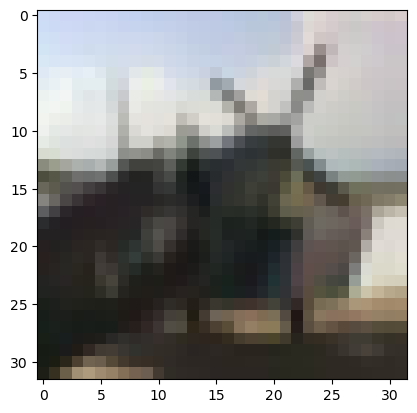

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [3]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [4]:
from torch import nn
import torch


class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.BatchNorm2d(in_channels)  # Better for conv layers than LayerNorm
        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=stride,
            stride=stride,
        )

    def forward(self, inputs):
        return self.downsample(self.norm(inputs))


class ConvNextBlock(nn.Module):
    def __init__(self, in_channels):
        super(ConvNextBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2, groups=in_channels)
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, 4 * in_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(4 * in_channels, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.norm(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x)
        return x + inputs  # Residual connection


class Classifier(nn.Module):
    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        self.stem = nn.Conv2d(in_channels=3, out_channels=n_initial_filters, kernel_size=1, stride=1)
        self.norm1 = nn.BatchNorm2d(n_initial_filters)

        current_n_filters = n_initial_filters
        layers = []

        for i in range(n_stages):
            for _ in range(blocks_per_stage):
                layers.append(ConvNextBlock(in_channels=current_n_filters))

            if i != n_stages - 1:
                layers.append(Downsampler(in_channels=current_n_filters, out_channels=2 * current_n_filters))
                current_n_filters *= 2  # Double the number of filters

        self.layers = nn.Sequential(*layers)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(current_n_filters),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(current_n_filters, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )

    def forward(self, inputs):
        x = self.stem(inputs)
        x = self.norm1(x)
        x = self.layers(x)
        x = nn.functional.avg_pool2d(x, kernel_size=x.shape[2:])
        x = self.head(x)
        return x

In [5]:
model = Classifier(64, 3, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 256, 8, 8]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         1,664
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    │    └─Dropout: 3-5                 [128, 64, 32, 32]         --
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         1,664
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         1

In [6]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    # Set model to training mode
    model.train()

    # Loop over batches
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass: compute predictions and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass: compute gradients and update parameters
        optimizer.zero_grad()  # Reset gradients before the backward pass
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update the progress bar
        progress_bar.update()

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [10]:
# Define the number of epochs
epochs = 40  # or any number of epochs you'd like to train for

# Store results for plotting or analysis later
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Training loop across epochs
for epoch in range(epochs):
    # Training phase
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {epoch + 1}/{epochs}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # Evaluate on training data
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Evaluate (Train) Epoch {epoch + 1}/{epochs}") as train_eval_bar:
        train_acc, train_loss_value = evaluate(train_dataloader, model, loss_fn, train_eval_bar)

    print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss_value:.3f}, Train Accuracy: {train_acc:.3f}%")
    train_loss.append(train_loss_value)
    train_accuracy.append(train_acc)

    # Validation phase
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {epoch + 1}/{epochs}") as val_bar:
        val_acc, val_loss_value = evaluate(val_dataloader, model, loss_fn, val_bar)

    print(f"Epoch {epoch + 1}/{epochs}: Validation Loss: {val_loss_value:.3f}, Validation Accuracy: {val_acc:.3f}%")
    val_loss.append(val_loss_value)
    val_accuracy.append(val_acc)

Train Epoch 1/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 1/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/40: Train Loss: 1.402, Train Accuracy: 48.415%


Validate Epoch 1/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/40: Validation Loss: 1.381, Validation Accuracy: 48.655%


Train Epoch 2/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 2/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/40: Train Loss: 1.163, Train Accuracy: 57.758%


Validate Epoch 2/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/40: Validation Loss: 1.162, Validation Accuracy: 57.437%


Train Epoch 3/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 3/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/40: Train Loss: 1.006, Train Accuracy: 63.770%


Validate Epoch 3/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/40: Validation Loss: 1.019, Validation Accuracy: 62.559%


Train Epoch 4/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 4/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/40: Train Loss: 0.949, Train Accuracy: 66.039%


Validate Epoch 4/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/40: Validation Loss: 0.957, Validation Accuracy: 64.616%


Train Epoch 5/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 5/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/40: Train Loss: 0.859, Train Accuracy: 69.594%


Validate Epoch 5/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/40: Validation Loss: 0.877, Validation Accuracy: 68.374%


Train Epoch 6/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 6/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/40: Train Loss: 0.804, Train Accuracy: 71.610%


Validate Epoch 6/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/40: Validation Loss: 0.830, Validation Accuracy: 69.699%


Train Epoch 7/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 7/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/40: Train Loss: 0.787, Train Accuracy: 71.546%


Validate Epoch 7/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/40: Validation Loss: 0.802, Validation Accuracy: 70.303%


Train Epoch 8/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 8/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/40: Train Loss: 0.703, Train Accuracy: 74.798%


Validate Epoch 8/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/40: Validation Loss: 0.728, Validation Accuracy: 73.339%


Train Epoch 9/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 9/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/40: Train Loss: 0.706, Train Accuracy: 75.372%


Validate Epoch 9/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/40: Validation Loss: 0.732, Validation Accuracy: 73.447%


Train Epoch 10/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 10/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/40: Train Loss: 0.655, Train Accuracy: 76.820%


Validate Epoch 10/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/40: Validation Loss: 0.695, Validation Accuracy: 74.634%


Train Epoch 11/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 11/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/40: Train Loss: 0.602, Train Accuracy: 79.166%


Validate Epoch 11/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/40: Validation Loss: 0.649, Validation Accuracy: 77.027%


Train Epoch 12/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 12/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/40: Train Loss: 0.594, Train Accuracy: 79.263%


Validate Epoch 12/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/40: Validation Loss: 0.633, Validation Accuracy: 77.265%


Train Epoch 13/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 13/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/40: Train Loss: 0.568, Train Accuracy: 80.174%


Validate Epoch 13/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/40: Validation Loss: 0.605, Validation Accuracy: 78.491%


Train Epoch 14/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 14/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/40: Train Loss: 0.570, Train Accuracy: 79.935%


Validate Epoch 14/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/40: Validation Loss: 0.616, Validation Accuracy: 77.621%


Train Epoch 15/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 15/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/40: Train Loss: 0.531, Train Accuracy: 81.535%


Validate Epoch 15/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/40: Validation Loss: 0.580, Validation Accuracy: 79.331%


Train Epoch 16/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 16/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/40: Train Loss: 0.522, Train Accuracy: 81.779%


Validate Epoch 16/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/40: Validation Loss: 0.578, Validation Accuracy: 79.381%


Train Epoch 17/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 17/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17/40: Train Loss: 0.525, Train Accuracy: 81.857%


Validate Epoch 17/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/40: Validation Loss: 0.584, Validation Accuracy: 79.727%


Train Epoch 18/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 18/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18/40: Train Loss: 0.498, Train Accuracy: 82.827%


Validate Epoch 18/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/40: Validation Loss: 0.561, Validation Accuracy: 80.063%


Train Epoch 19/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 19/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19/40: Train Loss: 0.494, Train Accuracy: 82.773%


Validate Epoch 19/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/40: Validation Loss: 0.549, Validation Accuracy: 80.409%


Train Epoch 20/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 20/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20/40: Train Loss: 0.498, Train Accuracy: 82.748%


Validate Epoch 20/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/40: Validation Loss: 0.562, Validation Accuracy: 80.291%


Train Epoch 21/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 21/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21/40: Train Loss: 0.493, Train Accuracy: 83.005%


Validate Epoch 21/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/40: Validation Loss: 0.557, Validation Accuracy: 80.489%


Train Epoch 22/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 22/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22/40: Train Loss: 0.469, Train Accuracy: 83.749%


Validate Epoch 22/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/40: Validation Loss: 0.537, Validation Accuracy: 81.003%


Train Epoch 23/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 23/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23/40: Train Loss: 0.469, Train Accuracy: 83.806%


Validate Epoch 23/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/40: Validation Loss: 0.515, Validation Accuracy: 81.448%


Train Epoch 24/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 24/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24/40: Train Loss: 0.452, Train Accuracy: 84.305%


Validate Epoch 24/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/40: Validation Loss: 0.518, Validation Accuracy: 81.932%


Train Epoch 25/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 25/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25/40: Train Loss: 0.435, Train Accuracy: 84.944%


Validate Epoch 25/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/40: Validation Loss: 0.505, Validation Accuracy: 81.893%


Train Epoch 26/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 26/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26/40: Train Loss: 0.446, Train Accuracy: 84.552%


Validate Epoch 26/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/40: Validation Loss: 0.517, Validation Accuracy: 81.814%


Train Epoch 27/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 27/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27/40: Train Loss: 0.420, Train Accuracy: 85.099%


Validate Epoch 27/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/40: Validation Loss: 0.493, Validation Accuracy: 81.903%


Train Epoch 28/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 28/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28/40: Train Loss: 0.422, Train Accuracy: 85.438%


Validate Epoch 28/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/40: Validation Loss: 0.493, Validation Accuracy: 83.070%


Train Epoch 29/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 29/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29/40: Train Loss: 0.413, Train Accuracy: 85.738%


Validate Epoch 29/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/40: Validation Loss: 0.490, Validation Accuracy: 82.595%


Train Epoch 30/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 30/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30/40: Train Loss: 0.417, Train Accuracy: 85.738%


Validate Epoch 30/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/40: Validation Loss: 0.483, Validation Accuracy: 83.010%


Train Epoch 31/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 31/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31/40: Train Loss: 0.421, Train Accuracy: 85.346%


Validate Epoch 31/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/40: Validation Loss: 0.495, Validation Accuracy: 82.644%


Train Epoch 32/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 32/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32/40: Train Loss: 0.414, Train Accuracy: 85.635%


Validate Epoch 32/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/40: Validation Loss: 0.496, Validation Accuracy: 82.911%


Train Epoch 33/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 33/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33/40: Train Loss: 0.384, Train Accuracy: 86.711%


Validate Epoch 33/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/40: Validation Loss: 0.465, Validation Accuracy: 83.633%


Train Epoch 34/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 34/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34/40: Train Loss: 0.402, Train Accuracy: 85.970%


Validate Epoch 34/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/40: Validation Loss: 0.491, Validation Accuracy: 82.536%


Train Epoch 35/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 35/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35/40: Train Loss: 0.424, Train Accuracy: 85.261%


Validate Epoch 35/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/40: Validation Loss: 0.506, Validation Accuracy: 82.011%


Train Epoch 36/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 36/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36/40: Train Loss: 0.381, Train Accuracy: 86.679%


Validate Epoch 36/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/40: Validation Loss: 0.465, Validation Accuracy: 83.248%


Train Epoch 37/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 37/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37/40: Train Loss: 0.369, Train Accuracy: 87.171%


Validate Epoch 37/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/40: Validation Loss: 0.449, Validation Accuracy: 83.970%


Train Epoch 38/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 38/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38/40: Train Loss: 0.377, Train Accuracy: 86.866%


Validate Epoch 38/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/40: Validation Loss: 0.463, Validation Accuracy: 83.525%


Train Epoch 39/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 39/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39/40: Train Loss: 0.368, Train Accuracy: 87.123%


Validate Epoch 39/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/40: Validation Loss: 0.463, Validation Accuracy: 83.910%


Train Epoch 40/40:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluate (Train) Epoch 40/40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40/40: Train Loss: 0.350, Train Accuracy: 87.647%


Validate Epoch 40/40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/40: Validation Loss: 0.443, Validation Accuracy: 84.296%


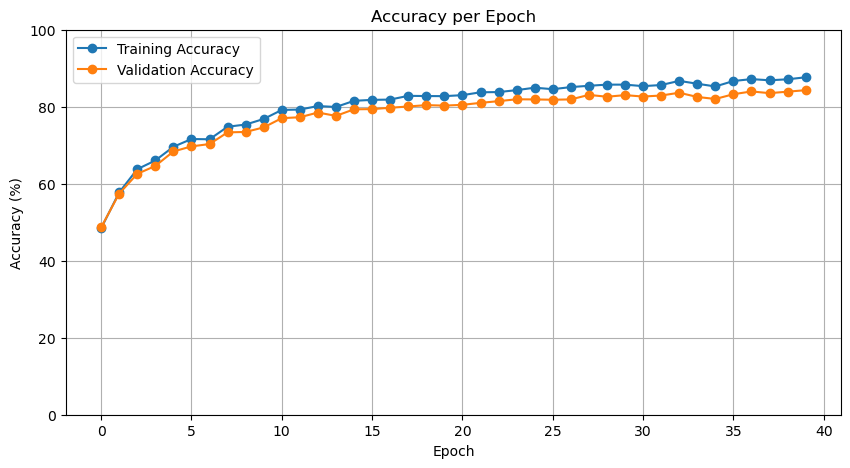

In [11]:
import matplotlib.pyplot as plt

# After training and validation loops
plt.figure(figsize=(10, 5))  # Optional: set figure size
plt.plot(train_accuracy, label='Training Accuracy', marker='o')  # Optional: add marker
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')  # Optional: add marker
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits to percentage
plt.legend()
plt.grid(True)  # Optional: add a grid for better readability
plt.show()  # Display the plot

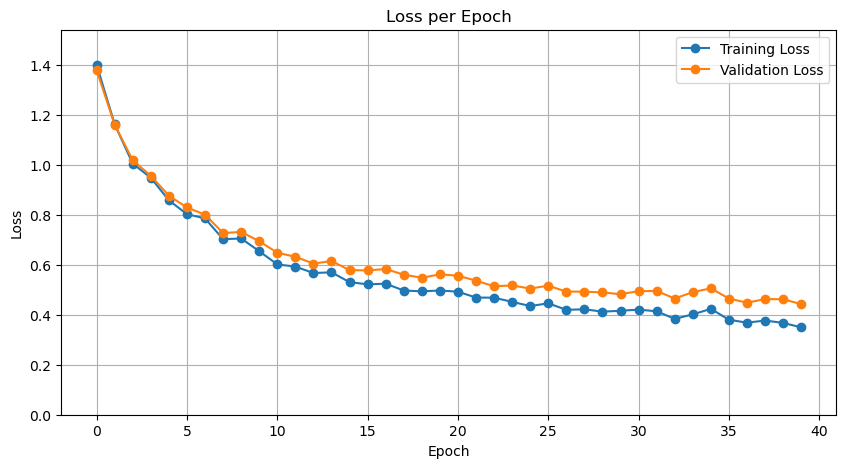

In [12]:
import matplotlib.pyplot as plt

# After training and validation loops
plt.figure(figsize=(10, 5))  # Optional: set figure size
plt.plot(train_loss, label='Training Loss', marker='o')  # Optional: add marker
plt.plot(val_loss, label='Validation Loss', marker='o')  # Optional: add marker
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_loss), max(val_loss)) * 1.1)  # Adjust y-axis limit if needed
plt.legend()
plt.grid(True)  # Optional: add a grid for better readability
plt.show()  # Display the plot

After making some adjustments to the model, we achieved a validation accuracy of about 80%. Here’s what I changed:

* Introduced an additional nn.Conv2d layer (layer 4).
* Increased the number of dense layers.
* Decreased the filter (kernel) size from 7 to 5, allowing the model to better capture finer details in the images.

Initially, the model was experiencing overfitting, with training accuracy exceeding 90% while validation accuracy fell below 80%. To combat this, I implemented DropOut layers between the dense layers and raised the weight decay parameter to strengthen the impact of L2 Regularization.

### Some Optimization and Improvements 

1.  pin_memory=True: Ensures faster transfer of batches from CPU to GPU by pinning memory.
2.	num_workers=4: Leverages multiple CPU cores to load data in parallel for faster data loading.
3.	Random Split Efficiency: Calculated the sizes of training and validation datasets explicitly.
4.	Reproducibility: Used manual_seed for splitting the dataset to ensure the same split every time.
5.	Code Clarity: Grouped import statements and added comments for easier readability.
6. Instead of passing shape (which can be inferred during runtime), we can use nn.GroupNorm or nn.BatchNorm2d in place of LayerNorm, as these are generally better suited for convolutional layers.
7. Letting PyTorch manage the shape dynamically makes the code simpler and avoids hardcoding dimensions.
8. Use functions from torch.nn.functional where possible to enhance flexibility (e.g., activation functions and padding).
9. 	Switched to BatchNorm2d for spatial data, as it’s better suited for convolutions.
10. Removed shape tracking: This reduces complexity, as shapes can be handled dynamically during the forward pass.
11. Used nn.functional where applicable for non-learnable operations like avg_pool2d.
12. Using .sum() without the need to cast to float, which is more efficient.
13. Passed batch_size explicitly instead of relying on a global variable.
14. Moved optimizer.zero_grad() before loss.backward(). This is generally the preferred order to ensure gradients are cleared before computing the new ones.
15. Changed j to epoch for better readability, and updated the range to start indexing from 1 for clarity during printing.
16. Updated the desc parameter in tqdm to provide more meaningful epoch progress descriptions, making it clear which phase (training or validation) is running and the total number of epochs.
17. Lists train_loss, train_accuracy, val_loss, and val_accuracy are updated consistently for both phases, ensuring correct storage for further analysis or visualization.
18. position=0 and leave=True ensure proper display of progress bars without overlapping or disappearing.


 